<a href="https://colab.research.google.com/github/JBtallgrass/UPENN_GSE_collab/blob/main/5_lab_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment: Analyzing Learner Interactions in MOOC Discussion Forums

In this assignment, we've taken the data from the forums of a previous iteration of the MOOC *Big Data
and Education*, from week 1.

The data set for this assignment has four columns:

- the post ID,
- the poster’s ID,
- the thread the post was in, and
- which post this post was a response to

Python code is provided below to help you get started but you can use any tool you want to complete this assignment.

Note: Different software packages may differ in how they name or calculate a specific measure (e.g., whether to normalize a centrality measure by default).

This assignment is focused on getting yourself familiar with the workflow of dealing with a realworld dataset from a digital learning platform, so don't worry about inconsistencies or "errors" when submitting your responses on ASSISTments.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Read data and preparing data

In NetworkX, you can read network data from different formats, such as `adjascency list`, `adjascency matrix`, `edge list`, etc.

In order to read data into NetworkX, you need to first transform your data into a proper format that is acceptable for NetworkX. This process applies to any other SNA software packages.

See [this NetworkX reference page](https://networkx.org/documentation/stable/reference/readwrite/index.html) for details.

### Let's first load the MOOC dataset and take a look

Let's read it in to a pandas dataframe and inspect its content.

In [2]:
df = pd.read_csv("https://learninganalytics.upenn.edu/ryanbaker/EDM2014/ba5-data.txt", delimiter='\t')

df = df.rename(columns={"response-to": "toID"})

df['toID'] = df['toID'].astype('Int64')

df.head(10)

,ID,poster,thread,toID
0,1,69497,1,<NA>
1,2,44591,2,<NA>
2,3,24601,2,2
3,4,74570,3,<NA>
4,5,29022,3,4
5,6,12345,3,5
6,7,24601,3,5
7,8,29022,3,7
8,9,24601,3,8
9,10,74577,4,<NA>


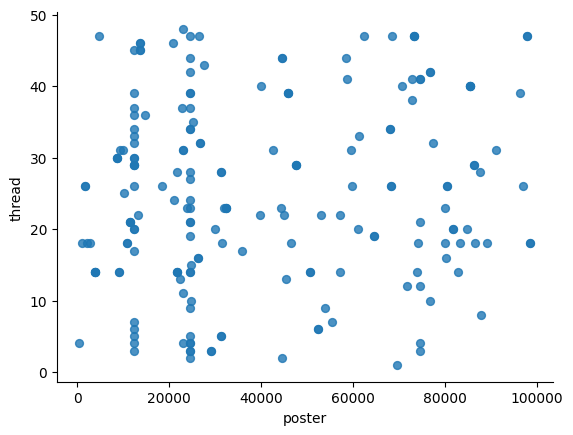

In [3]:
# @title poster vs thread

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='poster', y='thread', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
df.merge(df[pd.notnull(df.toID)][['ID', 'poster']], how='left', left_on='toID', right_on='ID')
# tmp = pd.merge(edge_list, edge_list[['ID', 'poster']], left_on='toID', right_on='ID', suffixes=('', '_receiver'))

,ID_x,poster_x,thread,toID,ID_y,poster_y
0,1,69497,1,<NA>,NaN,NaN
1,2,44591,2,<NA>,NaN,NaN
2,3,24601,2,2,NaN,NaN
3,4,74570,3,<NA>,NaN,NaN
4,5,29022,3,4,NaN,NaN
...,...,...,...,...,...,...
193,194,73263,47,193,193.0,24601.0
194,195,68491,47,193,193.0,24601.0
195,196,26362,47,195,195.0,68491.0
196,197,4582,47,195,195.0,68491.0


In [5]:
df[pd.notnull(df.toID)][['ID', 'poster']]

,ID,poster
2,3,24601
4,5,29022
5,6,12345
6,7,24601
7,8,29022
...,...,...
192,193,24601
193,194,73263
194,195,68491
195,196,26362


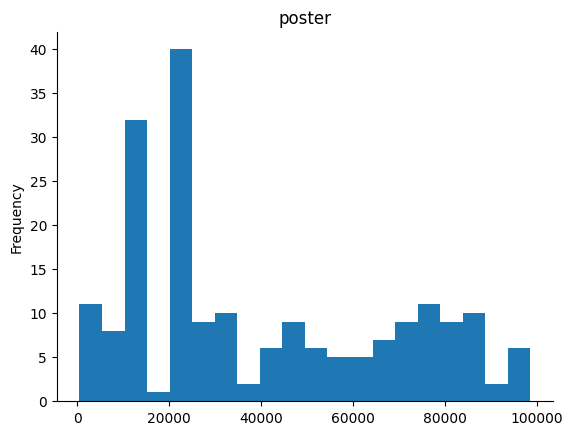

In [6]:
from matplotlib import pyplot as plt
df['poster'].plot(kind='hist', bins=20, title='poster')
plt.gca().spines[['top', 'right',]].set_visible(False)

The MOOC dataset is 'tidy' but it is not quite in an edgelist format, because the `response-to` column refers to the ID of a post instead of a student.

For example, row 3 of the dataframe is a response by student 24601 to post 2, which was created by student 44591.

To analyze student-to-student interactions, for each interaction, we need to trace the student who created the post replied by the current post.

For row 3, we need to add another column, named something like `receiver`, and fill it with 44591 to indicate the student who received the reply.

Besides this major data prep need, we also need to deal with these `NaN` values in the `response-to` column. These rows simply represent posts that were not replies. They are therefore not relevant to student-to-student interactions.

Finally, the last column seems to be treated as a `numeric` data type.

### Data prep

We first need to convert `response-to` to `Int64` to make sure its data type is consistent with the `ID` column.

In [7]:
df['response-to'] = df['toID'].astype('Int64')
df['response-to'] = df['response-to'].astype('Int64')
print(df.dtypes)
print(df)

ID             int64
poster         int64
thread         int64
toID           Int64
response-to    Int64
dtype: object
      ID  poster  thread  toID  response-to
0      1   69497       1  <NA>         <NA>
1      2   44591       2  <NA>         <NA>
2      3   24601       2     2            2
3      4   74570       3  <NA>         <NA>
4      5   29022       3     4            4
..   ...     ...     ...   ...          ...
193  194   73263      47   193          193
194  195   68491      47   193          193
195  196   26362      47   195          195
196  197    4582      47   195          195
197  198   22986      48  <NA>         <NA>

[198 rows x 5 columns]


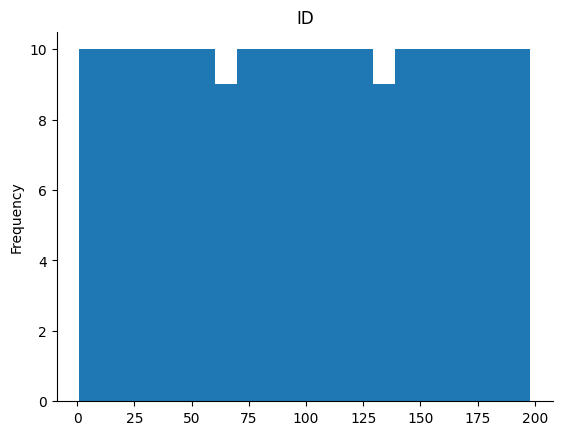

In [8]:
# @title ID

from matplotlib import pyplot as plt
df['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Prepare nodes

In [9]:
# Retrieve unique student IDs
node_list = pd.unique(df['poster'])

# Print the total number of nodes in the graph
print(len(node_list))

103


In [10]:
#df['poster'].value_counts()
# There are a number of ways you can identify the individual with the greatest number of posts. One of the simplest way is to use value_counts()

df['poster'].value_counts()


,count
poster,
24601,24
12345,21
85455,4
31345,4
3903,4
...,...
84726,1
46544,1
1008,1


#### Prepare edges

In [11]:
# Remove rows that do not have a receiver
edge_list = df.dropna()
print(edge_list)
print(df.columns)

# Create a new column receiver, by looking up values in the ID column
# This can be achieved using pd.merge
tmp = pd.merge(edge_list, edge_list[['ID', 'poster']], left_on='response-to', right_on='ID', suffixes=('', '_receiver'))
print(tmp)

edge_list = tmp.rename(columns={'poster_receiver': 'receiver'}).drop('ID_receiver', axis=1)

# Check the edgelist
edge_list

      ID  poster  thread  toID  response-to
2      3   24601       2     2            2
4      5   29022       3     4            4
5      6   12345       3     5            5
6      7   24601       3     5            5
7      8   29022       3     7            7
..   ...     ...     ...   ...          ...
192  193   24601      47   192          192
193  194   73263      47   193          193
194  195   68491      47   193          193
195  196   26362      47   195          195
196  197    4582      47   195          195

[150 rows x 5 columns]
Index(['ID', 'poster', 'thread', 'toID', 'response-to'], dtype='object')
      ID  poster  thread  toID  response-to  ID_receiver  poster_receiver
0      6   12345       3     5            5            5            29022
1      7   24601       3     5            5            5            29022
2      8   29022       3     7            7            7            24601
3      9   24601       3     8            8            8            29022
4    

,ID,poster,thread,toID,response-to,receiver
0,6,12345,3,5,5,29022
1,7,24601,3,5,5,29022
2,8,29022,3,7,7,24601
3,9,24601,3,8,8,29022
4,12,12345,4,11,11,24601
...,...,...,...,...,...,...
103,193,24601,47,192,192,62306
104,194,73263,47,193,193,24601
105,195,68491,47,193,193,24601
106,196,26362,47,195,195,68491


In [12]:
tmp['poster_receiver'].value_counts()

,count
poster_receiver,
12345,15
24601,14
29022,3
3903,3
21588,3
47634,3
32231,3
10827,3
98582,2


In [13]:
edge_list.to_csv('edgelist.csv', index=False)

## Create a directed network from data

With the cleaned edge list, we can create a directed graph, and add the edge list in.

There is a function named `add_edges_from` that can be used to quickly add the edges all at once.

However, we may want to keep two columns -- `ID` and `thread` -- as edge attributes. So we go through the edge list row by row and add one edge at a time with its attributes.

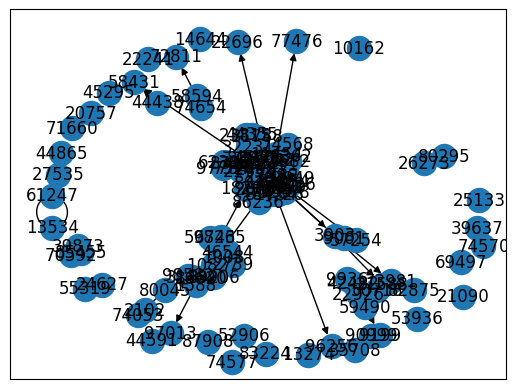

In [14]:
G = nx.DiGraph()

# Add nodes -- this is important because not all nodes are in edgelist
G.add_nodes_from(node_list)

# Add edges with attributes from the DataFrame to the graph
for _, row in edge_list.iterrows():
    G.add_edge(row['poster'], row['receiver'], id = row['ID'], thread=row['thread'])

# Generate a quick network visualization
nx.draw_networkx(G)




In [15]:

n = len(G.nodes())
total_possible_connections = (n * (n - 1))/2
print(total_possible_connections)

5253.0


In [16]:
undirected = G.to_undirected()
E = len(undirected.edges())
N = undirected.number_of_nodes()
density = 2 * E / (N * (N - 1))
print(density)

0.016181229773462782


In [17]:
distance = nx.shortest_path_length(G, source=12345, target=24601)
print(distance)

1


In [18]:
isolated = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
print(isolated)

[69497, 44591, 74570, 74577, 55319, 87908, 53936, 24627, 71660, 45295, 22241, 35708, 83224, 52906, 13274, 39637, 44865, 21090, 10162, 61247, 25133, 14644, 27535, 20757]


In [19]:
max_node, max_degree = max(G.in_degree(), key=lambda x: x[1])

print(max_node)

12345


In [20]:
print(G.number_of_nodes())
print(G.number_of_edges())

print(nx.shortest_path_length(G, 12345 and 24601))

print(nx.shortest_path_length(G, 87908))

#nx.center(G)

# G['poster'].value_counts(normalize=False, sort=True, ascending=True,
# bins=None, dropna=True)




103
98
{24601: 0, 29022: 1, 22986: 1, 12345: 1, 57254: 1, 3903: 1, 74568: 1, 31788: 1, 67949: 1, 45835: 1, 58431: 1, 62306: 1, 432: 2, 81734: 2, 1588: 2, 86236: 2, 47634: 2, 8639: 2, 77476: 2, 22696: 2, 96256: 2, 9061: 2, 73981: 2, 21588: 2, 11454: 2, 32231: 2, 73263: 2, 97013: 3, 68265: 3, 82875: 3, 50718: 3, 80033: 3, 97784: 3, 18299: 4, 80399: 5}
{87908: 0}


In [21]:
list(nx.selfloop_edges(G))

[(13534, 13534)]

This is odd, because `edge_list` has 108 rows.

Let's check attributes of the edge from `8639` to `12345`:

In [22]:
edge_list[(edge_list['poster'] == 87908)]

,ID,poster,thread,toID,response-to,receiver


In [23]:
G.get_edge_data(8639, 12345)

{'id': 131, 'thread': 30}

It's always a good idea to check the original dataset for any "bugs".

So let's check whether edges between these two nodes.

In [24]:
edge_list[(edge_list['poster'] == 8639) & (edge_list['receiver'] == 12345)]

,ID,poster,thread,toID,response-to,receiver
71,129,8639,30,128,128,12345
73,131,8639,30,130,130,12345


Interesting!!

Only the edge with ID of 153 is reflected in the NetworkX graph object.

This warrants additional investigation.

Aha! -- On the [DiGraph reference page](https://networkx.org/documentation/stable/reference/classes/digraph.html), there is one important sentence:

> DiGraphs hold directed edges. Self loops are allowed but multiple (parallel) edges are not.

It seems DiGraph only allows one edge between any pair of nodes, so some data were thrown away when multiple edges are observed between two nodes.

We need to find a solution to deal with this issue.

## Weighted directed network

There could be multiple solutions, depending on your goal.

One possible solution is to create a [`MultiDiGraph`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) -- A directed graph that can store multiedges. However, it's probably unnecessary since we are only dealing with one type of edges.

Another possible solution is to merge multiple edges into one weighted edge.

This preserves the number of occurrences but throws away the original edge attributes such as ID and thread.

Whether this is a good solution, again, depends on your goal.

### Created a new edge list data frame with a `weight` column

In [25]:
el_weighted = edge_list.groupby(['poster', 'receiver']).size().reset_index(name='weight')
el_weighted.sort_values(by=['weight', 'poster'], ascending=[False, True]) # Inspect the weighted edge list, sorted by weight and poster

,poster,receiver,weight
9,8639,12345,2
10,9061,3903,2
20,12345,24601,2
22,12345,47634,2
30,21588,50718,2
...,...,...,...
93,87525,21731,1
94,89206,86620,1
95,97784,73263,1
96,98582,10827,1


## Created a weighted directed network

Now, with the weighted edge list, we can follow the same process and generate a new network.

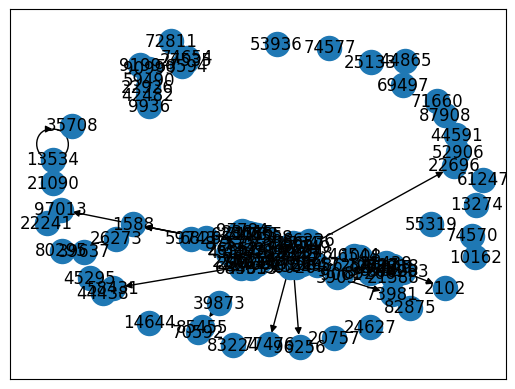

In [26]:
WG = nx.DiGraph()

# Add nodes
WG.add_nodes_from(node_list)

# Add edges with attributes from the DataFrame to the graph
for _, row in el_weighted.iterrows():
    WG.add_edge(row['poster'], row['receiver'], weight = row['weight'])

# Generate a quick network visualization
nx.draw_networkx(WG)

In [27]:
print(WG.number_of_nodes())
print(WG.number_of_edges())



103
98


In [28]:
list(nx.selfloop_edges(WG, data=True))

[(13534, 13534, {'weight': 1})]

In [29]:
WG.remove_edges_from(nx.selfloop_edges(WG))

Let's check the edge from `8639` to `12345` just to be safe:

In [30]:
WG.get_edge_data(8639, 12345)

{'weight': 2}

## Network analysis

With the created network, we can then conduct further analysis of the network.

Below are a few analyses for illustration purposes:

In [31]:
nx.shortest_path_length(WG, 12345, 24601)
nx.shortest_path_length(WG, 3903, 1588)

# nx.value_counts()

3

In [32]:
df['degree'] = pd.Series(nx.degree(G))
df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
df['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G, normalized = True))
df['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality(G))


df['degree_centrality'].value_counts()

,count
degree_centrality,


In [33]:
df['degree'] = pd.Series(nx.degree(G))
df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
df['degree_centrality'].value_counts()

,count
degree_centrality,


In [34]:
list(WG.successors(1588))
list(WG.successors(81734))

[12345]

In [35]:
list(WG.predecessors(1588))
list(WG.predecessors(87908))

[]

In [36]:
in_degrees = list(WG.in_degree(weight='weight'))
pd.DataFrame(in_degrees)

,0,1
0,69497,0
1,44591,0
2,24601,14
3,74570,0
4,29022,3
...,...,...
98,73263,2
99,62306,1
100,68491,2
101,26362,0


In [37]:
in_degrees

[(69497, 0),
 (44591, 0),
 (24601, 14),
 (74570, 0),
 (29022, 3),
 (12345, 15),
 (74577, 0),
 (432, 1),
 (22986, 1),
 (31345, 0),
 (52378, 0),
 (55319, 0),
 (87908, 0),
 (53936, 0),
 (24627, 0),
 (76712, 0),
 (71660, 0),
 (74568, 2),
 (45295, 0),
 (22241, 0),
 (3903, 3),
 (82875, 1),
 (73981, 2),
 (9061, 1),
 (21588, 3),
 (50718, 2),
 (57254, 1),
 (26273, 0),
 (80295, 1),
 (35708, 0),
 (83224, 0),
 (2102, 1),
 (74053, 1),
 (80045, 1),
 (98582, 2),
 (31439, 1),
 (86620, 1),
 (89206, 1),
 (2739, 1),
 (10827, 3),
 (1008, 0),
 (46544, 0),
 (64583, 0),
 (81734, 1),
 (84726, 0),
 (61054, 0),
 (30026, 0),
 (11454, 1),
 (52906, 0),
 (13274, 0),
 (39637, 0),
 (44865, 0),
 (32231, 3),
 (23815, 0),
 (31788, 1),
 (44355, 0),
 (80033, 1),
 (21090, 0),
 (10162, 0),
 (80399, 1),
 (97013, 1),
 (1588, 2),
 (18299, 1),
 (68265, 2),
 (59743, 0),
 (21731, 1),
 (87525, 1),
 (86236, 1),
 (47634, 3),
 (8639, 1),
 (22926, 1),
 (90999, 1),
 (9199, 1),
 (59490, 1),
 (42482, 1),
 (9936, 0),
 (26657, 0),
 (77476,

In [38]:
nx.density(WG)


0.009232819341328765

In [39]:
out_degrees = list(WG.out_degree(weight='weight'))
out_degrees
pd.DataFrame(out_degrees)

,0,1
0,69497,0
1,44591,0
2,24601,12
3,74570,0
4,29022,1
...,...,...
98,73263,2
99,62306,1
100,68491,1
101,26362,1


In [40]:
"{:.4f}".format(nx.overall_reciprocity(WG))

'0.2680'

### Prettify the network visualization

You can fine-tune the way the network is visualized, using features provided by NetworkX, or even other packages (such as `pyvis` that can generate interactive plots).

Below is a quick attempt to adjust the node size, edge width, coloring, and graph layout.

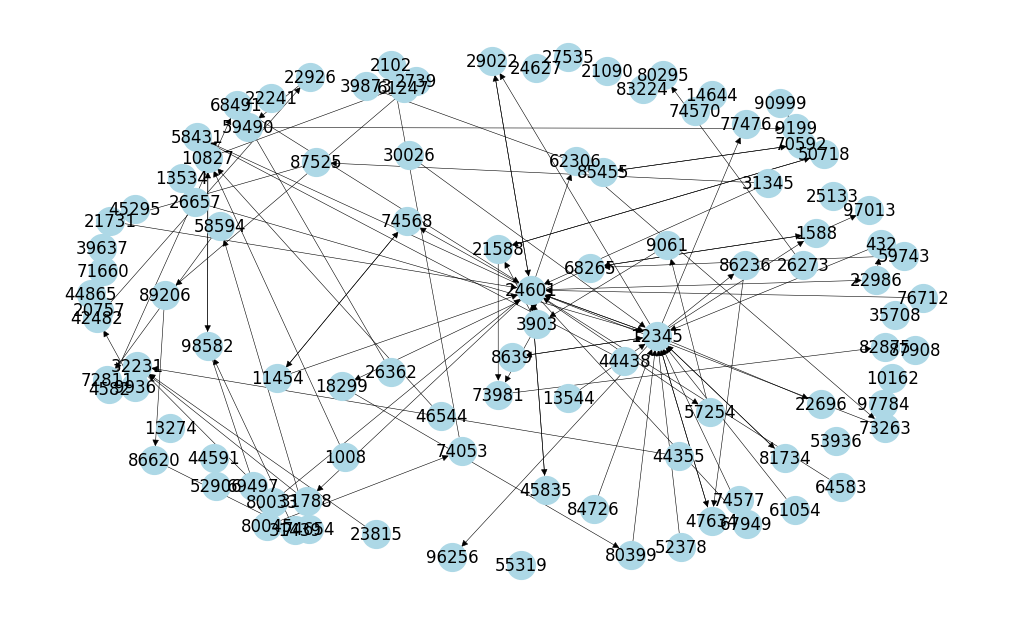

In [41]:
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(WG, k=0.8, iterations=50)
nx.draw(WG, pos , with_labels = True, width=0.4,
        node_color='lightblue', node_size=400)

In [42]:
poster = len(pd.unique(df['poster']))
connections = poster * (poster-1)/2
print("Number of Possible Connections:", connections)

Number of Possible Connections: 5253.0


In [43]:
density = poster / connections
print("Density:", round(density, 2))

Density: 0.02


In [44]:
geodesic_distance = nx.shortest_path_length(G, source=3903, target=1588)

In [45]:
print(geodesic_distance)

3


In [46]:
geodesic_distance1 = nx.shortest_path_length(G, source=12345, target=24601)
print(geodesic_distance1)

1


In [47]:
# List of posters to check for reachability
posters_to_check = [87908, 22986, 74568, 81734]

# Create a set of all nodes in the graph
all_nodes = set(G.nodes)

# Find reachable nodes from each poster
reachable_nodes = set()
for poster in posters_to_check:
    reachable_nodes.update(nx.single_source_shortest_path_length(G, source=poster).keys())

# Calculate the unreachable nodes
unreachable_nodes = all_nodes - reachable_nodes

print("Unreachable Poster Nodes:", unreachable_nodes)

Unreachable Poster Nodes: {23815, 68491, 22926, 27535, 20757, 98582, 55319, 83224, 44438, 52378, 74654, 26657, 26273, 80295, 76712, 52906, 25133, 80045, 44591, 53936, 10162, 24627, 2739, 14644, 2102, 61247, 70592, 44865, 39873, 44355, 74053, 64583, 74570, 10827, 30026, 31439, 9936, 74577, 85455, 46544, 39637, 13274, 86620, 13534, 59743, 22241, 21090, 59490, 58594, 21731, 87525, 4582, 13544, 72811, 71660, 45295, 90999, 31345, 9199, 1008, 42482, 89206, 84726, 69497, 26362, 35708, 61054}


In [48]:
unreachable_nodes = {23815, 68491, 22926, 27535, 20757, 98582, 55319, 83224, 44438, 52378, 74654, 26657, 26273, 80295, 76712, 52906, 25133, 80045, 44591, 53936, 10162, 24627, 2739, 14644, 2102, 61247, 70592, 44865, 39873, 44355, 74053, 64583, 74570, 10827, 30026, 31439, 9936, 74577, 85455, 46544, 39637, 13274, 86620, 13534, 59743, 22241, 21090, 59490, 58594, 21731, 87525, 4582, 13544, 72811, 71660, 45295, 90999, 31345, 9199, 1008, 42482, 89206, 84726, 69497, 26362, 35708, 61054}

poster_nodes = [87908, 22986, 74568, 81734]

# Check if any of the poster nodes exist in the list of unreachable nodes
unreachable_posters = [poster for poster in poster_nodes if poster in unreachable_nodes]

print("Unreachable Poster Nodes:", unreachable_posters)


Unreachable Poster Nodes: []


In [49]:
# List of posters to check for being receivers
poster_nodes = [87908, 22986, 74568, 81734]

# Initialize a list to store nodes that are not receivers
not_receivers = []

# Iterate over each poster node and check if it has incoming edges
for poster in poster_nodes:
    if poster not in G.nodes:
        # If the poster node is not even present in the graph, consider it as not a receiver
        not_receivers.append(poster)
    elif G.in_degree(poster) == 0:
        # If the poster node has no incoming edges, consider it as not a receiver
        not_receivers.append(poster)

print("Poster Nodes that are not receivers:", not_receivers)

Poster Nodes that are not receivers: [87908]


In [50]:
# Initialize a dictionary to store the number of posts made by each poster
posts_count = {}

# Iterate over each edge (post) in the graph
for u, v in G.edges:
    if u in posts_count:
        posts_count[u] += 1
    else:
        posts_count[u] = 1

# Find the poster with the maximum number of posts
most_posts_poster = max(posts_count, key=posts_count.get)
max_posts_count = posts_count[most_posts_poster]

print("Poster with the most posts:", most_posts_poster)
print("Number of posts made by the poster:", max_posts_count)

Poster with the most posts: 24601
Number of posts made by the poster: 11


In [51]:
# Calculate the in-degree of each node (poster)
in_degrees = dict(G.in_degree())

# Find the poster with the highest in-degree
most_responded_to = max(in_degrees, key=in_degrees.get)
max_in_degree = in_degrees[most_responded_to]

print("Poster who received the most responses:", most_responded_to)
print("Number of responses received:", max_in_degree)

Poster who received the most responses: 12345
Number of responses received: 13


[link text](https://)